In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys

from scipy.stats import pearsonr

sys.path.append("/kvh4/optic_disc/scripts") 
from training import train_dice, train_bce, train_dice_MC,train_bce_MC, run_inference, run_MC_inference
from evaluation_functions import compute_dice_dataset, \
                                    compute_max_softmax_uncertainty_dataset, load_pred, \
                                    compute_mean_uncertainty_dataset, \
                                    compute_mean_pw_dice_dataset

## Load Dataset Splits

In [2]:
filepath = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training"
with open(os.path.join(filepath, "dataset_splits_nonglaucoma_600_100.pkl"), 'rb') as file:
    data_dict = pickle.load(file)

In [3]:
glaucoma_image_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/images"
glaucoma_images = [os.path.join(glaucoma_image_dir, g) for g in os.listdir(glaucoma_image_dir)]
glaucoma_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"
glaucoma_gt = [os.path.join(glaucoma_gt_dir, g) for g in os.listdir(glaucoma_gt_dir)]

In [4]:
gt_dir_ng ="/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
gt_dir_g = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"

In [5]:
def eval_mean_uncertainty(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g, sampling=False):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=sampling)
    train_dice = np.mean(list(res_train.values()))
    unc_train = compute_mean_uncertainty_dataset(train_names, pred_dir_training, sampling=sampling)
    dice_train = list()
    ms_unc_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=sampling)
    test_dice = np.mean(list(res_test.values()))
    unc_test = compute_mean_uncertainty_dataset(test_names, pred_dir_test, sampling=sampling)
    dice_test = list()
    ms_unc_test = list()
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=sampling)
    g_dice = np.mean(list(res_g.values()))
    unc_g = compute_mean_uncertainty_dataset(g_names, pred_dir_g, sampling=sampling)
    dice_g = list()
    ms_unc_g = list()
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    
    plt.scatter(dice_train, ms_unc_train, label="training, "+str(round(train_dice, 3)))
    plt.scatter(dice_test, ms_unc_test, label="test non-glaucoma, "+str(round(test_dice, 3)))
    plt.scatter(dice_g, ms_unc_g, label="test glaucoma, "+str(round(g_dice, 3)))
    
    plt.ylabel("mean uncertainty")
    plt.xlabel("Dice score")
    plt.legend()
    
    return evaluation_data_dir

In [6]:
def eval_mean_pw_dice(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=True)
    train_dice = np.mean(list(res_train.values()))
    unc_train = compute_mean_pw_dice_dataset(train_names, pred_dir_training)
    dice_train = list()
    ms_unc_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=True)
    test_dice = np.mean(list(res_test.values()))
    unc_test = compute_mean_pw_dice_dataset(test_names, pred_dir_test)
    dice_test = list()
    ms_unc_test = list()
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=True)
    g_dice = np.mean(list(res_g.values()))
    unc_g = compute_mean_pw_dice_dataset(g_names, pred_dir_g)
    dice_g = list()
    ms_unc_g = list()
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    
    plt.scatter(dice_train, ms_unc_train, label="training, "+str(round(train_dice, 3)))
    plt.scatter(dice_test, ms_unc_test, label="test non-glaucoma, "+str(round(test_dice, 3)))
    plt.scatter(dice_g, ms_unc_g, label="test glaucoma, "+str(round(g_dice, 3)))
    
    plt.ylabel("mean pw Dice")
    plt.xlabel("Dice score")
    plt.legend()
    
    return evaluation_data_dir

## MC dice dropout
### seed = 0 
### p dropout = 0.05

In [8]:
training_params_MC_dice_05 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 200,
                  "model_dir": "/kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch",
                  "p_dropout": 0.05}

In [9]:
model_path = training_params_MC_dice_05["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_dice_05, file)

In [10]:
train_dice_MC(**training_params_MC_dice_05)

----------
epoch 1/200
epoch 1 average loss: 0.9558
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0764
val loss:  0.9554334336519241
----------
epoch 2/200
epoch 2 average loss: 0.9446
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.1028
val loss:  0.9418833369016647
----------
epoch 3/200
epoch 3 average loss: 0.9383
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1455
val loss:  0.9359503155946731
----------
epoch 4/200
epoch 4 average loss: 0.9327
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1964
val loss:  0.9286373162269592
----------
epoch 5/200
epoch 5 average loss: 0.9276
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.2270
val loss:  0.9184789538383484
----------
epoch 6/200
epoch 6 average loss: 0.9222
savepath:  /kvh4/optic_disc/mod

epoch 40 average loss: 0.6496
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_40.pth
saved model
current epoch: 40 current mean dice: 0.3905
val loss:  0.662114492058754
----------
epoch 41/200
epoch 41 average loss: 0.6408
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.4154
val loss:  0.6464323270320892
----------
epoch 42/200
epoch 42 average loss: 0.6278
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_42.pth
saved model
current epoch: 42 current mean dice: 0.3884
val loss:  0.6627110075950623
----------
epoch 43/200
epoch 43 average loss: 0.6289
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_43.pth
saved model
current epoch: 43 current mean dice: 0.4332
val loss:  0.6336099874973297
----------
epoch 44/200
epoch 44 average loss: 0.6152
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_44.pth
saved model
current epoch: 44 curren

current epoch: 78 current mean dice: 0.9321
val loss:  0.15995628952980043
----------
epoch 79/200
epoch 79 average loss: 0.1847
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_79.pth
saved model
current epoch: 79 current mean dice: 0.9326
val loss:  0.15100756168365478
----------
epoch 80/200
epoch 80 average loss: 0.1712
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_80.pth
saved model
current epoch: 80 current mean dice: 0.9325
val loss:  0.1459378844499588
----------
epoch 81/200
epoch 81 average loss: 0.1619
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_81.pth
saved model
current epoch: 81 current mean dice: 0.9324
val loss:  0.14199427366256714
----------
epoch 82/200
epoch 82 average loss: 0.1561
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_82.pth
saved model
current epoch: 82 current mean dice: 0.9331
val loss:  0.13149866938591004
----------
epoch 83/200
epoch 83 average loss: 0.1507
savepath

current epoch: 116 current mean dice: 0.9398
val loss:  0.07146878778934479
----------
epoch 117/200
epoch 117 average loss: 0.0790
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_117.pth
saved model
current epoch: 117 current mean dice: 0.9360
val loss:  0.07458694458007813
----------
epoch 118/200
epoch 118 average loss: 0.0781
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_118.pth
saved model
current epoch: 118 current mean dice: 0.9374
val loss:  0.07290221750736237
----------
epoch 119/200
epoch 119 average loss: 0.0788
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_119.pth
saved model
current epoch: 119 current mean dice: 0.9385
val loss:  0.0715496289730072
----------
epoch 120/200
epoch 120 average loss: 0.0771
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_120.pth
saved model
current epoch: 120 current mean dice: 0.9401
val loss:  0.06915306508541107
----------
epoch 121/200
epoch 121 average lo

epoch 154 average loss: 0.0631
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_154.pth
saved model
current epoch: 154 current mean dice: 0.9447
val loss:  0.05837362170219421
----------
epoch 155/200
epoch 155 average loss: 0.0615
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_155.pth
saved model
current epoch: 155 current mean dice: 0.9438
val loss:  0.0592615807056427
----------
epoch 156/200
epoch 156 average loss: 0.0620
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_156.pth
saved model
current epoch: 156 current mean dice: 0.9402
val loss:  0.0626017165184021
----------
epoch 157/200
epoch 157 average loss: 0.0637
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_157.pth
saved model
current epoch: 157 current mean dice: 0.9444
val loss:  0.058602481484413146
----------
epoch 158/200
epoch 158 average loss: 0.0634
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_158.pth
saved model
cu

current epoch: 191 current mean dice: 0.9448
val loss:  0.05621688604354858
----------
epoch 192/200
epoch 192 average loss: 0.0565
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_192.pth
saved model
current epoch: 192 current mean dice: 0.9448
val loss:  0.05638573467731476
----------
epoch 193/200
epoch 193 average loss: 0.0547
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_193.pth
saved model
current epoch: 193 current mean dice: 0.9454
val loss:  0.05578834235668182
----------
epoch 194/200
epoch 194 average loss: 0.0561
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_194.pth
saved model
current epoch: 194 current mean dice: 0.9471
val loss:  0.05409933567047119
----------
epoch 195/200
epoch 195 average loss: 0.0592
savepath:  /kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch/epoch_195.pth
saved model
current epoch: 195 current mean dice: 0.9456
val loss:  0.05560946464538574
----------
epoch 196/200
epoch 196 average l

In [13]:
model_dir = "/kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch"
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

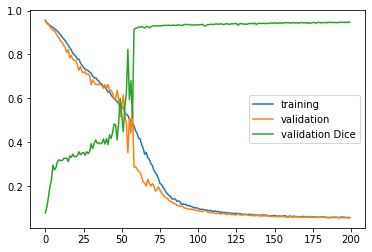

In [14]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [7]:
eval_epoch_dice_MC = 125

#### validation data

In [39]:
model_dir = "/kvh4/optic_disc/models/11_MC_UNet_p05_cup_nopatch"
eval_epoch_dice_MC = 75

MC_pred_params_val_05 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_dice_MC, 
                  "test_images":  data_dict["validation_images"],
                  "test_gt": data_dict["validation_gt"], 
                  "save_dir": os.path.join(model_dir, "validation_preds_epoch_"+str(eval_epoch_dice_MC)), 
                  "iterations":10,
                  "dropout": .05
                 }

In [40]:
run_MC_inference(**MC_pred_params_val_05)

finished inference


In [41]:
val_names = [n[-9:-4] for n in data_dict["validation_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
MC_dice_val = compute_dice_dataset(val_names, ng_gt_dir, MC_pred_params_val_05["save_dir"], mode="cup", sampling=True)
MC_unc_val = compute_mean_uncertainty_dataset(val_names, MC_pred_params_val_05["save_dir"], sampling=True)

In [42]:
MC_pw_dice_val = compute_mean_pw_dice_dataset(val_names, MC_pred_params_val_05["save_dir"])

In [43]:
# no patches
np.mean(list(MC_dice_val.values()))

0.9240646805391941

In [89]:
# patch prediction
np.mean(list(MC_dice_val.values()))

0.8494671986708959

In [44]:
dice = list()
ms_unc = list()
pw_dice = list()
for k in MC_dice_val.keys():
    dice.append(MC_dice_val[k])
    ms_unc.append(MC_unc_val[k])
    pw_dice.append(MC_pw_dice_val[k])

Text(0, 0.5, 'mean pw Dice')

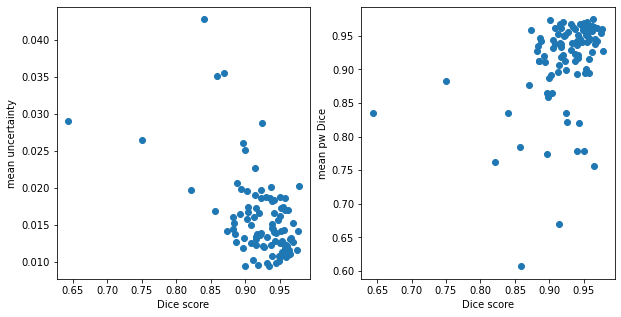

In [45]:
# no patches
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

Text(0, 0.5, 'mean pw Dice')

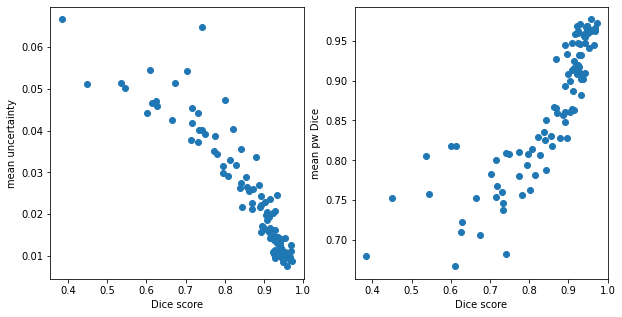

In [91]:
# patches
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [75]:
pearsonr(dice, ms_unc)

(-0.905609234306701, 2.7576261058890003e-38)

In [76]:
pearsonr(dice, pw_dice)

(0.8116271703569751, 1.3028899820214095e-24)

In [46]:
pearsonr(dice, ms_unc)

(-0.5401414196868753, 6.6342469301072635e-09)

In [47]:
pearsonr(dice, pw_dice)

(0.38039124728470675, 9.465290909607159e-05)

In [22]:
run_MC_inference(**MC_pred_params_test_05)

finished inference


In [23]:
pred = np.load(os.path.join(MC_pred_params["save_dir"], "V0382.npy"))
pred.shape

(512, 512, 20)

In [24]:
test_names = [n[-9:-4] for n in data_dict["test_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
MC_dice = compute_dice_dataset(test_names, ng_gt_dir, MC_pred_params["save_dir"], mode="cup", sampling=True)
MC_unc = compute_mean_uncertainty_dataset(test_names, MC_pred_params["save_dir"], sampling=True)

In [25]:
np.mean(list(MC_dice.values()))

0.8609254071136236

In [26]:
dice = list()
ms_unc = list()
for k in MC_dice.keys():
    dice.append(MC_dice[k])
    ms_unc.append(MC_unc[k])

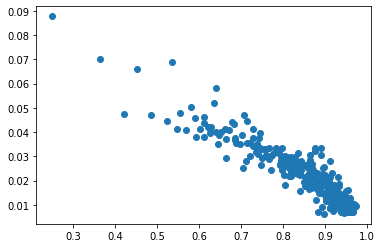

In [27]:
plt.scatter(dice, ms_unc)

## dropout rate = .10

In [48]:
training_params_MC_dice_10 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch",
                  "p_dropout": 0.10}

In [49]:
model_path = training_params_MC_dice_10["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_dice_10, file)

In [50]:
train_dice_MC(**training_params_MC_dice_10)

----------
epoch 1/100
epoch 1 average loss: 0.9568
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0734
val loss:  0.9564651346206665
----------
epoch 2/100
epoch 2 average loss: 0.9463
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.1066
val loss:  0.9428245007991791
----------
epoch 3/100
epoch 3 average loss: 0.9400
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1462
val loss:  0.9356894487142563
----------
epoch 4/100
epoch 4 average loss: 0.9350
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1898
val loss:  0.9284865075349807
----------
epoch 5/100
epoch 5 average loss: 0.9301
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.2378
val loss:  0.9195643305778504
----------
epoch 6/100
epoch 6 average loss: 0.9249
savepath:  /kvh4/optic_disc/mod

epoch 40 average loss: 0.6629
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_40.pth
saved model
current epoch: 40 current mean dice: 0.3884
val loss:  0.663611501455307
----------
epoch 41/100
epoch 41 average loss: 0.6574
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.3931
val loss:  0.6622333598136901
----------
epoch 42/100
epoch 42 average loss: 0.6413
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_42.pth
saved model
current epoch: 42 current mean dice: 0.3919
val loss:  0.6620772218704224
----------
epoch 43/100
epoch 43 average loss: 0.6399
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_43.pth
saved model
current epoch: 43 current mean dice: 0.3911
val loss:  0.6563954430818558
----------
epoch 44/100
epoch 44 average loss: 0.6312
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_44.pth
saved model
current epoch: 44 curren

current epoch: 78 current mean dice: 0.9174
val loss:  0.17182595789432525
----------
epoch 79/100
epoch 79 average loss: 0.2815
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_79.pth
saved model
current epoch: 79 current mean dice: 0.9257
val loss:  0.14970265686511994
----------
epoch 80/100
epoch 80 average loss: 0.2654
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_80.pth
saved model
current epoch: 80 current mean dice: 0.9244
val loss:  0.15497980237007142
----------
epoch 81/100
epoch 81 average loss: 0.2483
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_81.pth
saved model
current epoch: 81 current mean dice: 0.9241
val loss:  0.15713538765907287
----------
epoch 82/100
epoch 82 average loss: 0.2455
savepath:  /kvh4/optic_disc/models/09_MC_UNet_p10_cup_nopatch/epoch_82.pth
saved model
current epoch: 82 current mean dice: 0.9245
val loss:  0.16171529531478882
----------
epoch 83/100
epoch 83 average loss: 0.2238
savepat

In [25]:
model_dir = "/kvh4/optic_disc/models/09_MC_UNet_p10_cup"
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

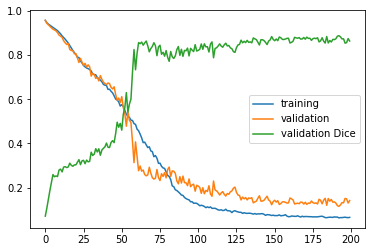

In [26]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [51]:
model_dir = "/kvh4/optic_disc/models/09_MC_UNet_p10_cup"
eval_epoch_dice_MC = 193

MC_pred_params_val_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_dice_MC, 
                  "test_images":  data_dict["validation_images"],
                  "test_gt": data_dict["validation_gt"], 
                  "save_dir": os.path.join(model_dir, "validation_preds_epoch_"+str(eval_epoch_dice_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

In [52]:
run_MC_inference(**MC_pred_params_val_10)

finished inference


In [56]:
val_names = [n[-9:-4] for n in data_dict["validation_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"

MC_dice_val = compute_dice_dataset(val_names, ng_gt_dir, MC_pred_params_val_10["save_dir"], mode="cup", sampling=True)
MC_unc_val = compute_mean_uncertainty_dataset(val_names, MC_pred_params_val_10["save_dir"], sampling=True)
MC_pw_dice_val = compute_mean_pw_dice_dataset(val_names, MC_pred_params_val_10["save_dir"])

In [57]:
np.mean(list(MC_dice_val.values()))

0.8432214099673903

In [58]:
dice = list()
ms_unc = list()
pw_dice = list()
for k in MC_dice_val.keys():
    dice.append(MC_dice_val[k])
    ms_unc.append(MC_unc_val[k])
    pw_dice.append(MC_pw_dice_val[k])

Text(0, 0.5, 'mean pw Dice')

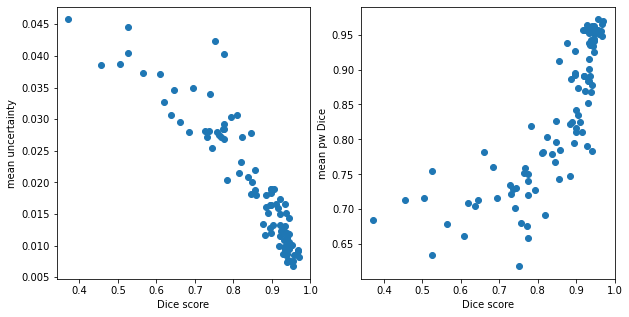

In [48]:
# 30 iterations
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [53]:
pearsonr(dice, ms_unc)

(-0.9190069825140201, 2.1173236711981354e-41)

In [50]:
pearsonr(dice, pw_dice)

(0.7949323331580779, 5.416423169900779e-23)

Text(0, 0.5, 'mean pw Dice')

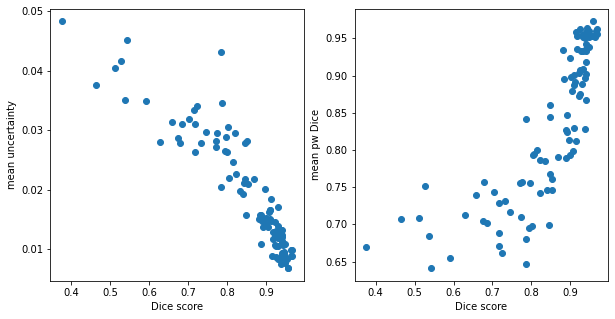

In [40]:
# 20 iterations
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [59]:
pearsonr(dice, ms_unc)

(-0.8949469936577574, 4.014402363414603e-36)

In [60]:
pearsonr(dice, pw_dice)

(0.8020805592870437, 1.1468202361036495e-23)

Text(0, 0.5, 'mean pw Dice')

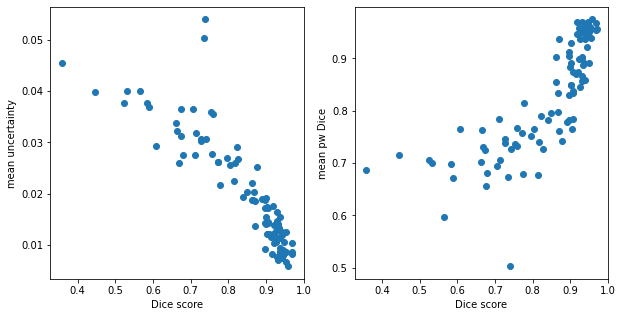

In [32]:
# 10 iterations
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

### run training, test, and glaucoma inference

In [112]:
model_dir = "/kvh4/optic_disc/models/09_MC_UNet_p10_cup"
eval_epoch_dice_MC = 193

MC_pred_params_train_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_dice_MC, 
                  "test_images":  data_dict["training_images"],
                  "test_gt": data_dict["training_gt"], 
                  "save_dir": os.path.join(model_dir, "training_preds_epoch_"+str(eval_epoch_dice_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

run_MC_inference(**MC_pred_params_train_10)

finished inference


In [113]:
MC_pred_params_test_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_dice_MC, 
                  "test_images":  data_dict["test_images"],
                  "test_gt": data_dict["test_gt"], 
                  "save_dir": os.path.join(model_dir, "test_preds_epoch_"+str(eval_epoch_dice_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

run_MC_inference(**MC_pred_params_test_10)

finished inference


In [114]:
MC_pred_params_glaucoma_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_dice_MC, 
                  "test_images":  glaucoma_images,
                  "test_gt": glaucoma_gt, 
                  "save_dir": os.path.join(model_dir, "glaucoma_preds_epoch_"+str(eval_epoch_dice_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

run_MC_inference(**MC_pred_params_glaucoma_10)

finished inference


## dropout rate = .20

In [17]:
training_params_MC_dice_20 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch",
                  "p_dropout": 0.20}

In [18]:
model_path = training_params_MC_dice_20["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_dice_20, file)

In [ ]:
train_dice_MC(**training_params_MC_dice_20)

----------
epoch 1/150
epoch 1 average loss: 0.9587
savepath:  /kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0652
val loss:  0.9582722097635269
----------
epoch 2/150
epoch 2 average loss: 0.9489
savepath:  /kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.1075
val loss:  0.9459736222028732
----------
epoch 3/150
epoch 3 average loss: 0.9430
savepath:  /kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1455
val loss:  0.9385602700710297
----------
epoch 4/150
epoch 4 average loss: 0.9387
savepath:  /kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1823
val loss:  0.9309800463914871
----------
epoch 5/150
epoch 5 average loss: 0.9342
savepath:  /kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.2384
val loss:  0.9223366492986679
----------
epoch 6/150
epoch 6 average loss: 0.9299
savepath:  /kvh4/optic_disc/mod

In [21]:
model_dir = "/kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch"
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

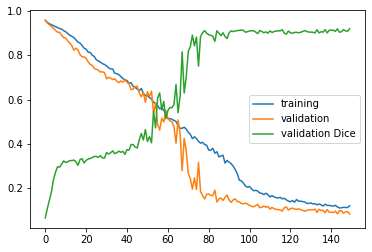

In [22]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [50]:
model_dir = "/kvh4/optic_disc/models/04_MC_UNet_p20_cup_nopatch"
eval_epoch_dice_MC = 140

MC_pred_params_val_20 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_dice_MC, 
                  "test_images":  data_dict["validation_images"],
                  "test_gt": data_dict["validation_gt"], 
                  "save_dir": os.path.join(model_dir, "validation_preds_epoch_"+str(eval_epoch_dice_MC)), 
                  "iterations":10,
                  "dropout": .20
                 }

In [51]:
run_MC_inference(**MC_pred_params_val_20)

finished inference


In [52]:
val_names = [n[-9:-4] for n in data_dict["validation_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"

MC_dice_val = compute_dice_dataset(val_names, ng_gt_dir, MC_pred_params_val_20["save_dir"], mode="cup", sampling=True)
MC_unc_val = compute_mean_uncertainty_dataset(val_names, MC_pred_params_val_20["save_dir"], sampling=True)
MC_pw_dice_val = compute_mean_pw_dice_dataset(val_names, MC_pred_params_val_20["save_dir"])

In [53]:
np.mean(list(MC_dice_val.values()))

0.8902063665116141

In [54]:
dice = list()
ms_unc = list()
pw_dice = list()
for k in MC_dice_val.keys():
    dice.append(MC_dice_val[k])
    ms_unc.append(MC_unc_val[k])
    pw_dice.append(MC_pw_dice_val[k])

Text(0, 0.5, 'mean pw Dice')

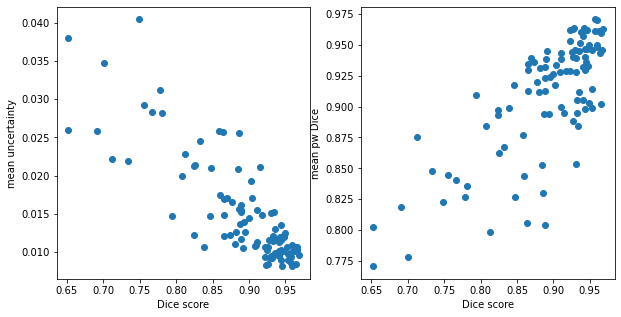

In [55]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [56]:
pearsonr(dice, ms_unc)

(-0.8338192736880251, 4.9566204952517016e-27)

In [57]:
pearsonr(dice, pw_dice)

(0.7645298745550179, 2.1304241841810512e-20)

# BCE MC dropout model

### seed = 0 
### p dropout = 0.05

In [13]:
training_params_MC_bce_05 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 250,
                  "model_dir": "/kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup",
                  "p_dropout": 0.05,
                    "pos_weight": 10}

In [14]:
model_path = training_params_MC_bce_05["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_bce_05, file)

In [ ]:
train_bce_MC(**training_params_MC_bce_05)

----------
epoch 1/250
epoch 1 average loss: 0.8407
savepath:  /kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup/epoch_1.pth
saved model
current epoch: 1 current mean dice: 0.0667
val loss:  0.7212812358140945
----------
epoch 2/250
epoch 2 average loss: 0.7540
savepath:  /kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0917
val loss:  0.7010986560583115
----------
epoch 3/250
epoch 3 average loss: 0.6961
savepath:  /kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1155
val loss:  0.6574962836503982
----------
epoch 4/250
epoch 4 average loss: 0.6518
savepath:  /kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1445
val loss:  0.6180455392599106
----------
epoch 5/250
epoch 5 average loss: 0.6110
savepath:  /kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.

In [19]:
model_dir = "/kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup"
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

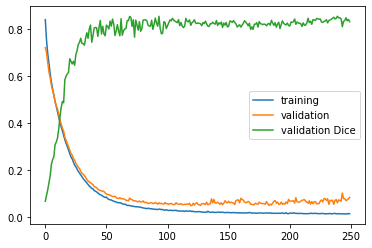

In [20]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [22]:
np.argmax(val_metrics[100:150])

4

In [69]:
eval_epoch_bce_MC_05 = 200

#### validation data

In [79]:
model_dir = "/kvh4/optic_disc/models/12_MC_UNet_bce_p05_cup"
eval_epoch_bce_MC_05 = 75

MC_pred_params_val_05 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_bce_MC_05, 
                  "test_images":  data_dict["validation_images"],
                  "test_gt": data_dict["validation_gt"], 
                  "save_dir": os.path.join(model_dir, "validation_preds_epoch_"+str(eval_epoch_bce_MC_05)), 
                  "iterations":10,
                  "dropout": .05
                 }

In [80]:
run_MC_inference(**MC_pred_params_val_05)

finished inference


In [81]:
val_names = [n[-9:-4] for n in data_dict["validation_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
MC_dice_val = compute_dice_dataset(val_names, ng_gt_dir, MC_pred_params_val_05["save_dir"], mode="cup", sampling=True)
MC_unc_val = compute_mean_uncertainty_dataset(val_names, MC_pred_params_val_05["save_dir"], sampling=True)

In [82]:
MC_pw_dice_val = compute_mean_pw_dice_dataset(val_names, MC_pred_params_val_05["save_dir"])

In [83]:
np.mean(list(MC_dice_val.values()))

0.8938066619408922

In [84]:
dice = list()
ms_unc = list()
pw_dice = list()
for k in MC_dice_val.keys():
    dice.append(MC_dice_val[k])
    ms_unc.append(MC_unc_val[k])
    pw_dice.append(MC_pw_dice_val[k])

Text(0, 0.5, 'mean pw Dice')

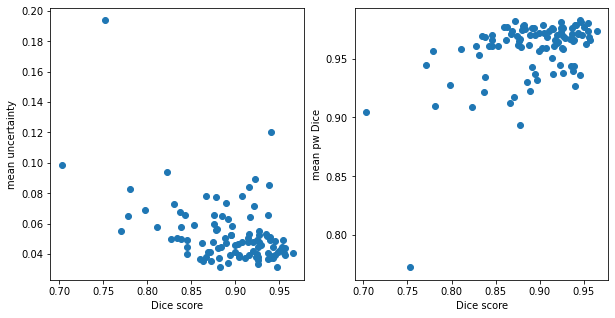

In [85]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [86]:
pearsonr(dice, ms_unc)

(-0.43895838328530434, 4.912381274102477e-06)

In [87]:
pearsonr(dice, pw_dice)

(0.4874948374580794, 2.6903165598767307e-07)

### seed = 0 
### p dropout = 0.10

In [33]:
training_params_MC_bce_10 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 300,
                  "model_dir": "/kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup",
                  "p_dropout": 0.10, 
                             "pos_weight": 10}

In [34]:
model_path = training_params_MC_bce_10["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_bce_10, file)

In [ ]:
train_bce_MC(**training_params_MC_bce_10)

----------
epoch 1/300
epoch 1 average loss: 0.8530
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0663
val loss:  0.7237461531162261
----------
epoch 2/300
epoch 2 average loss: 0.7737
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0865
val loss:  0.7033985263109207
----------
epoch 3/300
epoch 3 average loss: 0.7178
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1118
val loss:  0.6600071668624878
----------
epoch 4/300
epoch 4 average loss: 0.6737
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1366
val loss:  0.618135085105896
----------
epoch 5/300
epoch 5 average loss: 0.6314
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.1690
val loss:  0.587845647931099
----------
epoch 6/300
epoch 6 average loss: 0.5924
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce

current epoch: 40 current mean dice: 0.8250
val loss:  0.1482400868088007
----------
epoch 41/300
epoch 41 average loss: 0.1288
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.7864
val loss:  0.13967994518578053
----------
epoch 42/300
epoch 42 average loss: 0.1257
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_42.pth
saved model
current epoch: 42 current mean dice: 0.7913
val loss:  0.1351529785990715
----------
epoch 43/300
epoch 43 average loss: 0.1229
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_43.pth
saved model
current epoch: 43 current mean dice: 0.8026
val loss:  0.13007453702390193
----------
epoch 44/300
epoch 44 average loss: 0.1157
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_44.pth
saved model
current epoch: 44 current mean dice: 0.7700
val loss:  0.12779377222061158
----------
epoch 45/300
epoch 45 average loss: 0.1156
savepath:  /kvh4/optic_di

current epoch: 79 current mean dice: 0.8072
val loss:  0.06458331268280744
----------
epoch 80/300
epoch 80 average loss: 0.0481
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_80.pth
saved model
current epoch: 80 current mean dice: 0.8514
val loss:  0.06209486037492752
----------
epoch 81/300
epoch 81 average loss: 0.0453
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_81.pth
saved model
current epoch: 81 current mean dice: 0.8376
val loss:  0.06822021059691906
----------
epoch 82/300
epoch 82 average loss: 0.0495
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_82.pth
saved model
current epoch: 82 current mean dice: 0.8370
val loss:  0.06920458994805813
----------
epoch 83/300
epoch 83 average loss: 0.0474
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_83.pth
saved model
current epoch: 83 current mean dice: 0.8298
val loss:  0.062190310284495356
----------
epoch 84/300
epoch 84 average loss: 0.0464
savepath:  /kvh4/optic

epoch 118 average loss: 0.0302
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_118.pth
saved model
current epoch: 118 current mean dice: 0.8309
val loss:  0.05188120011240244
----------
epoch 119/300
epoch 119 average loss: 0.0310
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_119.pth
saved model
current epoch: 119 current mean dice: 0.8261
val loss:  0.05049957321956754
----------
epoch 120/300
epoch 120 average loss: 0.0291
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_120.pth
saved model
current epoch: 120 current mean dice: 0.8217
val loss:  0.04940367667004466
----------
epoch 121/300
epoch 121 average loss: 0.0270
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_121.pth
saved model
current epoch: 121 current mean dice: 0.8308
val loss:  0.05318047259002924
----------
epoch 122/300
epoch 122 average loss: 0.0285
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_122.pth
saved model
current epoch: 122 cu

epoch 156 average loss: 0.0223
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_156.pth
saved model
current epoch: 156 current mean dice: 0.8493
val loss:  0.047502731084823606
----------
epoch 157/300
epoch 157 average loss: 0.0228
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_157.pth
saved model
current epoch: 157 current mean dice: 0.8398
val loss:  0.05949562745168805
----------
epoch 158/300
epoch 158 average loss: 0.0213
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_158.pth
saved model
current epoch: 158 current mean dice: 0.8384
val loss:  0.06253069693222642
----------
epoch 159/300
epoch 159 average loss: 0.0194
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_159.pth
saved model
current epoch: 159 current mean dice: 0.8460
val loss:  0.05432474460452795
----------
epoch 160/300
epoch 160 average loss: 0.0203
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_160.pth
saved model
current epoch: 160 c

epoch 194 average loss: 0.0178
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_194.pth
saved model
current epoch: 194 current mean dice: 0.8326
val loss:  0.06970967032015324
----------
epoch 195/300
epoch 195 average loss: 0.0173
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_195.pth
saved model
current epoch: 195 current mean dice: 0.8425
val loss:  0.06166998215019703
----------
epoch 196/300
epoch 196 average loss: 0.0174
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_196.pth
saved model
current epoch: 196 current mean dice: 0.8194
val loss:  0.08638627573847771
----------
epoch 197/300
epoch 197 average loss: 0.0165
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_197.pth
saved model
current epoch: 197 current mean dice: 0.8466
val loss:  0.06190162070095539
----------
epoch 198/300
epoch 198 average loss: 0.0170
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_198.pth
saved model
current epoch: 198 cu

epoch 232 average loss: 0.0154
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_232.pth
saved model
current epoch: 232 current mean dice: 0.8215
val loss:  0.09003080507740378
----------
epoch 233/300
epoch 233 average loss: 0.0149
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_233.pth
saved model
current epoch: 233 current mean dice: 0.8418
val loss:  0.06829293999820947
----------
epoch 234/300
epoch 234 average loss: 0.0153
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_234.pth
saved model
current epoch: 234 current mean dice: 0.8065
val loss:  0.10056007232517004
----------
epoch 235/300
epoch 235 average loss: 0.0160
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_235.pth
saved model
current epoch: 235 current mean dice: 0.8290
val loss:  0.07405148036777973
----------
epoch 236/300
epoch 236 average loss: 0.0151
savepath:  /kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup/epoch_236.pth
saved model
current epoch: 236 cu

In [39]:
model_dir = "/kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup"
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

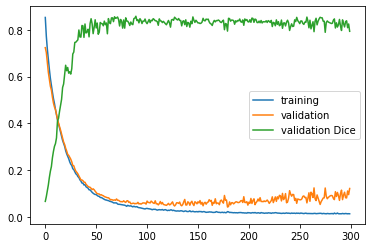

In [40]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [110]:
eval_epoch_bce_MC = 175

#### validation data

In [101]:
model_dir = "/kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup"
eval_epoch_bce_MC = 200

MC_pred_params_val_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_bce_MC, 
                  "test_images":  data_dict["validation_images"],
                  "test_gt": data_dict["validation_gt"], 
                  "save_dir": os.path.join(model_dir, "validation_preds_epoch_"+str(eval_epoch_bce_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

In [102]:
run_MC_inference(**MC_pred_params_val_10)

finished inference


In [103]:
val_names = [n[-9:-4] for n in data_dict["validation_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
MC_dice_val = compute_dice_dataset(val_names, ng_gt_dir, MC_pred_params_val_10["save_dir"], mode="cup", sampling=True)
MC_unc_val = compute_mean_uncertainty_dataset(val_names, MC_pred_params_val_10["save_dir"], sampling=True)

In [104]:
MC_pw_dice_val = compute_mean_pw_dice_dataset(val_names, MC_pred_params_val_10["save_dir"])

In [105]:
# epoch 200
np.mean(list(MC_dice_val.values()))

0.7658517109741478

In [96]:
# epoch 175
np.mean(list(MC_dice_val.values()))

0.7972105158006983

In [91]:
# epoch 150
np.mean(list(MC_dice_val.values()))

0.7675433694729165

In [106]:
dice = list()
ms_unc = list()
pw_dice = list()
for k in MC_dice_val.keys():
    dice.append(MC_dice_val[k])
    ms_unc.append(MC_unc_val[k])
    pw_dice.append(MC_pw_dice_val[k])

Text(0, 0.5, 'mean pw Dice')

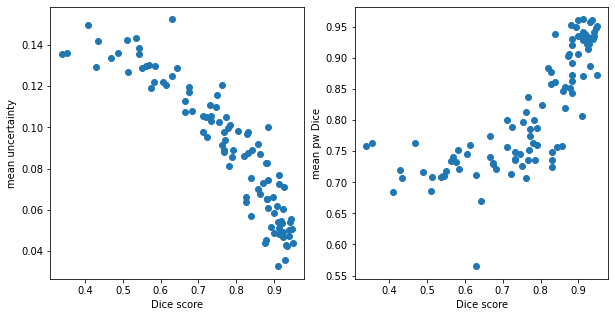

In [107]:
# epoch 200
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [108]:
pearsonr(dice, ms_unc)

(-0.9057852182236428, 2.5275836248190555e-38)

In [109]:
pearsonr(dice, pw_dice)

(0.7794684402600972, 1.2733546054829213e-21)

Text(0, 0.5, 'mean pw Dice')

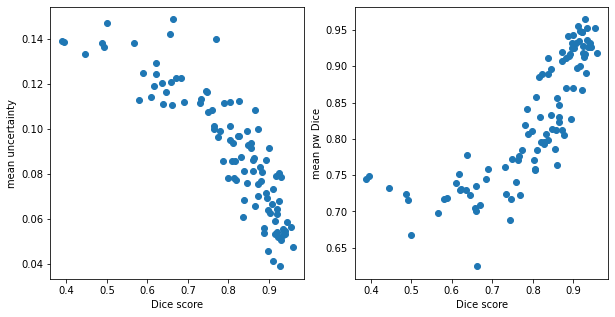

In [98]:
# epoch 175
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [99]:
pearsonr(dice, ms_unc)

(-0.8660864089600461, 2.859476806104524e-31)

In [100]:
pearsonr(dice, pw_dice)

(0.8120901847515112, 1.1687847327919389e-24)

Text(0, 0.5, 'mean pw Dice')

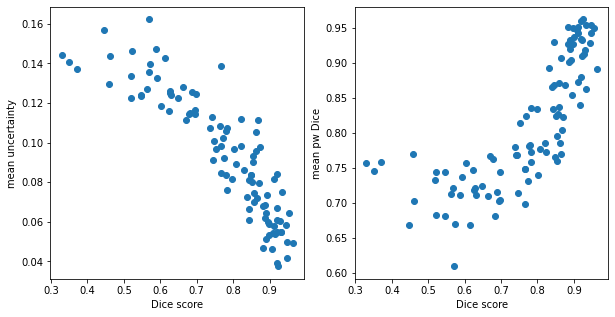

In [88]:
# epoch 150

pearsonr(dice, pw_dice)
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [89]:
pearsonr(dice, ms_unc)

(-0.8838681902631352, 4.1467444452190196e-34)

In [90]:
pearsonr(dice, pw_dice)

(0.77961598788058, 1.2370626214246279e-21)

Text(0, 0.5, 'mean pw Dice')

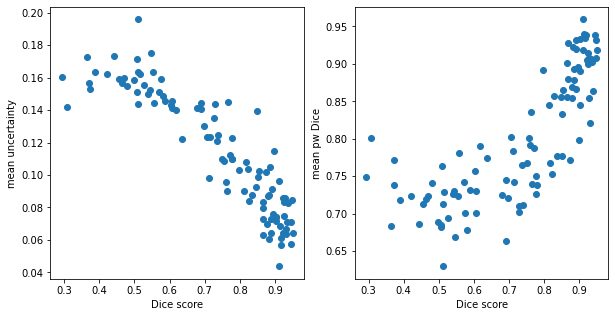

In [72]:
# epoch 89

pearsonr(dice, pw_dice)
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [73]:
pearsonr(dice, ms_unc)

(-0.8988396129857048, 6.94943999991557e-37)

In [74]:
pearsonr(dice, pw_dice)

(0.7844483781864211, 4.739028264542406e-22)

In [115]:
model_dir = "/kvh4/optic_disc/models/13_MC_UNet_bce_p10_cup"
eval_epoch_bce_MC = 175

MC_pred_params_train_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_bce_MC, 
                  "test_images":  data_dict["training_images"],
                  "test_gt": data_dict["training_gt"], 
                  "save_dir": os.path.join(model_dir, "training_preds_epoch_"+str(eval_epoch_bce_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

run_MC_inference(**MC_pred_params_train_10)

finished inference


In [116]:
MC_pred_params_test_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_bce_MC, 
                  "test_images":  data_dict["test_images"],
                  "test_gt": data_dict["test_gt"], 
                  "save_dir": os.path.join(model_dir, "test_preds_epoch_"+str(eval_epoch_bce_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

run_MC_inference(**MC_pred_params_test_10)

finished inference


In [117]:
MC_pred_params_glaucoma_10 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_bce_MC, 
                  "test_images":  glaucoma_images,
                  "test_gt": glaucoma_gt, 
                  "save_dir": os.path.join(model_dir, "glaucoma_preds_epoch_"+str(eval_epoch_bce_MC)), 
                  "iterations":20,
                  "dropout": .10
                 }

run_MC_inference(**MC_pred_params_glaucoma_10)

finished inference


### seed = 0 
### p dropout = 0.20

In [55]:
training_params_MC_bce_20 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 300,
                  "model_dir": "/kvh4/optic_disc/models/13_MC_UNet_bce_p20_cup",
                  "p_dropout": 0.20,
                            "pos_weight": 10}

In [ ]:
model_path = training_params_MC_bce_20["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_bce_20, file)

In [ ]:
train_bce_MC(**training_params_MC_bce_20)

In [57]:
model_dir = "/kvh4/optic_disc/models/13_MC_UNet_bce_p20_cup"
train_loss = np.load(os.path.join(model_dir, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_dir, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_dir, "val_metrics.npy"))

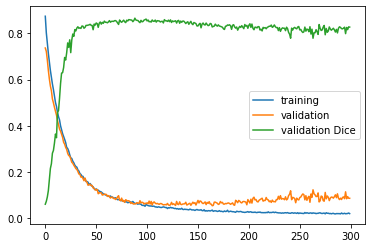

In [58]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [62]:
np.argmax(val_metrics[100:])

17

In [64]:
eval_epoch_dice_MC = 118

#### validation data

In [104]:
model_dir = "/kvh4/optic_disc/models/13_MC_UNet_bce_p20_cup"
eval_epoch_bce_MC = 250

MC_pred_params_val_20 = {"model_dir": model_dir, 
                  "model_epoch": eval_epoch_bce_MC, 
                  "test_images":  data_dict["validation_images"],
                  "test_gt": data_dict["validation_gt"], 
                  "save_dir": os.path.join(model_dir, "validation_preds_epoch_"+str(eval_epoch_bce_MC)), 
                  "iterations":20,
                  "dropout": .20
                 }

In [105]:
run_MC_inference(**MC_pred_params_val_20)

finished inference


In [106]:
val_names = [n[-9:-4] for n in data_dict["validation_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
MC_dice_val = compute_dice_dataset(val_names, ng_gt_dir, MC_pred_params_val_20["save_dir"], mode="cup", sampling=True)
MC_unc_val = compute_mean_uncertainty_dataset(val_names, MC_pred_params_val_20["save_dir"], sampling=True)

In [107]:
MC_pw_dice_val = compute_mean_pw_dice_dataset(val_names, MC_pred_params_val_20["save_dir"])

In [108]:
np.mean(list(MC_dice_val.values()))

0.8839367542208776

In [109]:
dice = list()
ms_unc = list()
pw_dice = list()
for k in MC_dice_val.keys():
    dice.append(MC_dice_val[k])
    ms_unc.append(MC_unc_val[k])
    pw_dice.append(MC_pw_dice_val[k])

Text(0, 0.5, 'mean pw Dice')

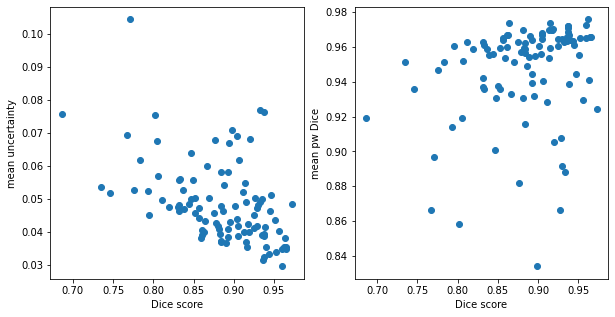

In [110]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.subplot(1,2,2)
plt.scatter(dice, pw_dice)
plt.xlabel("Dice score")
plt.ylabel("mean pw Dice")

In [111]:
pearsonr(dice, ms_unc)

(-0.47896703481578606, 4.6315527239807126e-07)

In [112]:
pearsonr(dice, pw_dice)

(0.25194030962008407, 0.011449966316912849)